In [1]:
import sys
sys.path.append('./source_code')

In [290]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.axes
import pickle
import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, learning_curve, cross_val_score, \
    KFold, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, \
    roc_auc_score, roc_curve, confusion_matrix
import xgboost as xgb
import classification_helpers as ch
from matplotlib.ticker import StrMethodFormatter

%config InlineBackend.figure_format = 'svg'
%matplotlib inline
# sns.set(color_codes=True)
custom_palette = ['#0081A7', '#00AFB9', '#FDFCDC', '#FED9B7', '#F07167']
sns.set_palette(custom_palette)
# plt.style.use('seaborn-colorblind')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.precision', 2)
pd.set_option('display.max_info_columns', 200)

In [3]:
with open('pickles/combined_sample_weather_df5.pickle', 'rb') as read_file:
    sample_df = pickle.load(read_file)

In [5]:
base_numerical_features = ['airline_avg_arrival_delay',
                           'origin_airport_avg_flights_per_day',
                           'origin_airport_avg_departure_delay',
                           'destination_airport_avg_flights_per_day',
                           'destination_airport_avg_arrival_delay',
                           'month_avg_delay',
                           'day_of_week_avg_delay']

weather_numerical_features = ['Precipitation_origin',
                              'Snow Depth_origin',
                              'Visibility_origin',
                              'Wind Speed_origin',                      
                              'Precipitation_destination',
                              'Snow Depth_destination',
                              'Visibility_destination',
                              'Wind Speed_destination']
                              

weather_categorical_features = ['is_Clear_origin',
                                'is_Partially cloudy_origin',
                                'is_Rain_origin',
                                'is_Snow_origin',
                                'is_Overcast_origin',
                                'is_Clear_destination',
                                'is_Partially cloudy_destination',
                                'is_Rain_destination',
                                'is_Snow_destination',
                                'is_Overcast_destination']

base_categorical_features = ['American Airlines Inc.', 'American Eagle Airlines Inc.',
                             'Atlantic Southeast Airlines', 'Delta Air Lines Inc.',
                             'Frontier Airlines Inc.', 'Hawaiian Airlines Inc.', 'JetBlue Airways',
                             'Skywest Airlines Inc.', 'Southwest Airlines Co.', 'Spirit Air Lines',
                             'US Airways Inc.', 'United Air Lines Inc.', 'Virgin America',
                             'is_thanksgiving_period', 'is_xmas_period',
                             'is_night_departure', 'is_night_arrival']

target = ['is_not_on_time']

all_features = (base_numerical_features 
                + base_categorical_features 
                + weather_numerical_features)

In [71]:
X, y = ch.feature_target_selection(all_features, target, sample_df)

X_train_val, X_test, y_train_val, y_test = ch.initial_split(X, y.values.ravel())
X_train, X_val, y_train, y_val = ch.second_split(X_train_val, y_train_val)

lm = LogisticRegression(penalty='none', max_iter=10000)
lm_balanced = LogisticRegression(penalty='none', max_iter=10000, class_weight='balanced')

rf = RandomForestClassifier()
rf_balanced = RandomForestClassifier(n_estimators=100, max_depth=6, class_weight='balanced')

In [7]:
ch.test_scores(lm_balanced, X_train_val, X_test,
               y_train_val, y_test,
               threshold=.47, scale=True)

Model name: LogisticRegression
Hyperparameters: class_weight='balanced', max_iter=10000, penalty='none'

Train F1:                                 0.40
Test F1:                                  0.39
Train precision:                          0.28
Test precision:                           0.28
Train recall:                             0.66
Test recall:                              0.65
Train accuracy:                           0.60
Test accuracy:                            0.59
Train AUC:                                0.62
Test AUC:                                 0.61

Feature coefficients:

airline_avg_arrival_delay                 0.06
origin_airport_avg_flights_per_day        0.02
origin_airport_avg_departure_delay        0.13
destination_airport_avg_flights_per_day   0.04
destination_airport_avg_arrival_delay     0.11
month_avg_delay                           0.22
day_of_week_avg_delay                     0.04
American Airlines Inc.                   -0.02
American Eagle Airlines I

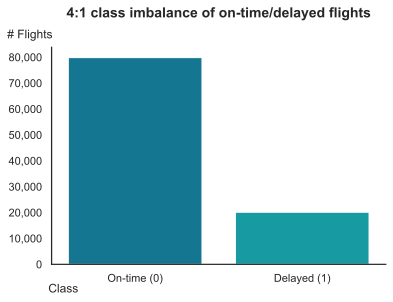

In [367]:
# Change data to 'On-time (0)' and 'Delayed (1)' 
# Change color palette
# Change ylabel and title coordinates to match Alice's 
fig, ax = plt.subplots()
# fig.set_size_inches([10, 5])

sns.countplot(x='is_not_on_time', data=sample_df, palette=['#0081A7', '#00AFB9'])
sns.set_style("white")
sns.despine()
ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
ax.set_xlabel('Class')
ax.set_ylabel('# Flights', rotation=0)       
ax.set_xticklabels(['On-time (0)', 'Delayed (1)'])
ax.set_title('4:1 class imbalance of on-time/delayed flights', loc='center',
             fontweight='bold', fontsize=14, pad=30);
ax.xaxis.set_label_coords(.035, -.09)
ax.yaxis.set_label_coords(-0.065, 1.03)
plt.savefig('visualizations/class_imbalance_bar.svg');

In [303]:
feature_names = X_train_val.columns
scaler = StandardScaler()
X_train_val_scaled = scaler.fit_transform(X_train_val)
X_test_scaled = scaler.transform(X_test)
model = lm_balanced.fit(X_train_val_scaled, y_train_val)

In [304]:
threshold = 0.47
y_test_pred = np.where(model.predict_proba(X_test_scaled)[:, 1] > threshold, 1, 0)
cm = confusion_matrix(y_test, y_test_pred)

In [305]:
cm

array([[9189, 6752],
       [1418, 2635]])

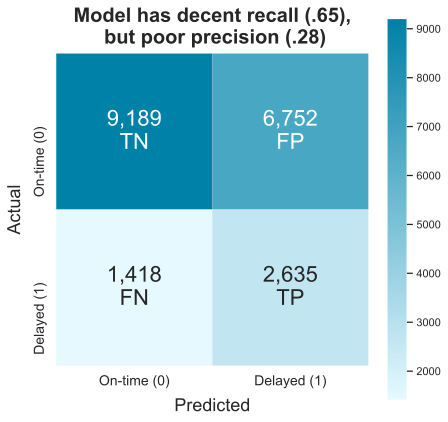

In [397]:
fig, ax = plt.subplots()
fig.set_size_inches(7, 7)
cmap = sns.light_palette('#0081A7', as_cmap=True)
custom_annot = (['9,189\nTN', '6,752\nFP'], 
                ['1,418\nFN', '2,635\nTP'])

sns.heatmap(cm,
            cmap=cmap,
            annot=custom_annot,
            fmt = '',
            square=True,            
            annot_kws={"size": 22})

ax.set_xticklabels(['On-time (0)', 'Delayed (1)'], fontsize=14)
ax.set_yticklabels(['On-time (0)', 'Delayed (1)'], fontsize=14)
ax.set_ylabel('Actual', labelpad=10, fontsize=18)
ax.set_xlabel('Predicted', labelpad=10, fontsize=18)
ax.set_title('Model has decent recall (.65),\n but poor precision (.28)',
             loc='center', fontweight='bold', fontsize=20, pad=10)
plt.savefig('visualizations/confusion_matrix.svg');

In [73]:
coef = list(zip(feature_names, model.coef_[0]))

In [74]:
coef = sorted(coef, key=lambda x: abs(x[1]), reverse=True)

In [202]:
coef_dict = dict(coef)

In [368]:
len(coef_dict)

32

In [204]:
coef_df = pd.DataFrame(coef_dict, index=range(1)).T.reset_index()

In [205]:
coef_df.columns = ['Features', 'Coefficients']

In [270]:
airline_coef = ['Delta Air Lines Inc.', 'Spirit Air Lines',
                'Southwest Airlines Co.', 'Frontier Airlines Inc.']

weather_coef = ['Visibility_origin', 'Precipitation_destination',
                'Wind Speed_destination', 'Precipitation_origin',
                'Visibility_destination', 'Wind Speed_origin']

time_coef = ['is_night_arrival', 'month_avg_delay',
             'day_of_week_avg_delay', 'is_thanksgiving_period',
             'is_xmas_period']

In [256]:
weather_coef_df = coef_df[coef_df['Features'].isin(weather_coef)].reset_index(drop=True)

In [217]:
airline_coef_df = coef_df[coef_df['Features'].isin(airline_coef)].reset_index(drop=True)

In [271]:
time_coef_df = coef_df[coef_df['Features'].isin(time_coef)].reset_index(drop=True)

In [272]:
time_coef_df

,Features,Coefficients
0,is_night_arrival,0.23
1,month_avg_delay,0.22
2,day_of_week_avg_delay,0.04
3,is_thanksgiving_period,-0.03
4,is_xmas_period,0.03


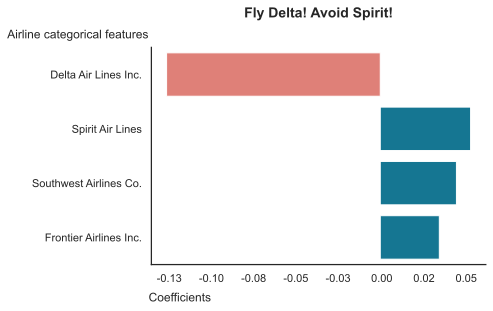

In [365]:
# Break up feature importance into categories: flight-specific, airline, weather 
# (and plot bar chart for each)
fig, ax = plt.subplots()

palette = ['#F07167', '#0081A7', '#0081A7', '#0081A7']
sns.barplot(x='Coefficients', y='Features', data=airline_coef_df, palette=palette)
sns.despine()

ax.set_ylabel('Airline categorical features', rotation=0)       
ax.set_title('Fly Delta! Avoid Spirit!', loc='center',
             fontweight='bold', fontsize=14, pad=30);
ax.xaxis.set_label_coords(.085, -.13)
ax.xaxis.set_major_formatter((StrMethodFormatter('{x: .2f}')))
ax.yaxis.set_label_coords(-0.22, 1.03);
plt.savefig('visualizations/airline_features.svg');

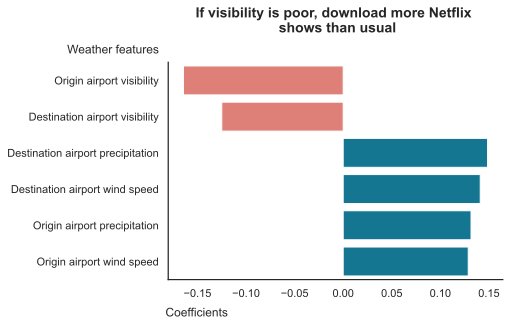

In [374]:
fig, ax = plt.subplots()
palette = ['#F07167'] * 2 + ['#0081A7'] * 4
order = ['Visibility_origin', 'Visibility_destination',
         'Precipitation_destination', 'Wind Speed_destination',
         'Precipitation_origin', 'Wind Speed_origin']

yaxis_labels = ['Origin airport visibility', 'Destination airport visibility',
                'Destination airport precipitation', 'Destination airport wind speed',
                'Origin airport precipitation', 'Origin airport wind speed']
sns.barplot(x='Coefficients', y='Features',
            data=weather_coef_df, order=order, palette=palette)
sns.despine()
ax.set_yticklabels(yaxis_labels)
ax.set_ylabel('Weather features', rotation=0)
ax.set_title('If visibility is poor, download more Netflix \n shows than usual',
             loc='center', fontweight='bold', fontsize=14, pad=30)
ax.xaxis.set_label_coords(.085, -.13)
ax.yaxis.set_label_coords(-0.165, 1.03);

In [275]:
time_coef_df

,Features,Coefficients
0,is_night_arrival,0.23
1,month_avg_delay,0.22
2,day_of_week_avg_delay,0.04
3,is_thanksgiving_period,-0.03
4,is_xmas_period,0.03


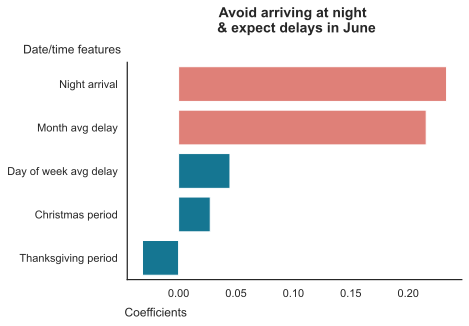

In [282]:
fig, ax = plt.subplots()
palette = ['#F07167'] * 2 + ['#0081A7'] * 4
order = ['is_night_arrival', 'month_avg_delay', 
         'day_of_week_avg_delay', 'is_xmas_period', 
         'is_thanksgiving_period']
yaxis_labels = ['Night arrival', 'Month avg delay',
               'Day of week avg delay', 'Christmas period',
               'Thanksgiving period']
sns.barplot(x='Coefficients', y='Features', data=time_coef_df, order=order, palette=palette)
sns.despine()
ax.set_yticklabels(yaxis_labels)
ax.set_ylabel('Date/time features', rotation=0)
ax.set_title('Avoid arriving at night \n & expect delays in June', 
             loc='center', fontweight='bold', fontsize=14, pad=30)
ax.xaxis.set_label_coords(.085, -.13)
ax.yaxis.set_label_coords(-0.165, 1.03);

In [336]:
len(set(sample_df['origin_airport_name'].values))

319

In [337]:
sample_df.head()

,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_arrival_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_arrival_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_arrival_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in,destination_airport_avg_taxi_in,date_str,origin_airport_coordinates,destination_airport_coordinates,Address_origin,Cloud Cover_origin,Conditions_origin,Date time_origin,Dew Point_origin,Heat Index_origin,Info_origin,Latitude_origin,Longitude_origin,Maximum Temperature_origin,Minimum Temperature_origin,Name_origin,Precipitation_origin,Precipitation Cover_origin,Relative Humidity_origin,Resolved Address_origin,Sea Level Pressure_origin,Snow Depth_origin,Temperature_origin,Visibility_origin,Weather Type_origin,Wind Chill_origin,Wind Direction_origin,Wind Gust_origin,Wind Speed_origin,Address_destination,Cloud Cover_destination,Conditions_destination,Date time_destination,Dew Point_destination,Heat Index_destination,Info_destination,Latitude_destination,Longitude_destination,Maximum Temperature_destination,Minimum Temperature_destination,Name_destination,Precipitation_destination,Precipitation Cover_destination,Relative Humidity_destination,Resolved Address_destination,Sea Level Pressure_destination,Snow Depth_destination,Temperature_destination,Visibility_destination,Weather Type_destination,Wind Chill_destination,Wind Direction_destination,Wind Gust_destination,Wind Speed_destination,is_Overcast_origin,is_Rain_origin,is_Snow_origin,is_Partially cloudy_origin,is_Clear_origin,is_Overcast_destination,is_Rain_destination,is_Snow_destination,is_Partially cloudy_destination,is_Clear_destination
0,2015,2,13,5,EV,4210,N26141,IAH,BNA,1904,1900,-4.0,18.0,1918,107,113.0,89.0,657,2047,6.0,2051,2053,2.0,0,0,None,NaN,NaN,NaN,NaN,NaN,Atlantic Southeast Airlines,George Bush Intercontinental Airport,Houston,TX,29.98,-95.34,Nashville International Airport,Nashville,TN,36.12,-86.68,0,11.72,46,254,9877,3.04,0,0,1,0,0,0,0,0,0,0,0,0,0,10.82,2540.0,6.96,6.90,815.0,2.23,902.0,9.13,964.0,9.76,17.14,6.63,0,0,0,1,9.0,16.67,7.62,12.04,17.83,7.12,6.28,2015-02-13,"29.98047,-95.33972","36.12448,-86.67818","29.98047,-95.33972",39.3,Partially cloudy,02/13/2015,39.6,NaN,,29.98,-95.34,65.9,39,,0.0,0.0,64.60,"29.98047,-95.33972",1026.6,0.0,52.2,1.0,,34.7,135.13,NaN,12.7,"36.12448,-86.67818",51.5,Partially cloudy,02/13/2015,9.9,NaN,,36.12,-86.68,35.9,19.1,,0.00,0.00,50.54,"36.12448,-86.67818",1026.9,0.0,26.8,1.0,,10.2,251.40,NaN,8.1,0,0,0,1,0,0,0,0,1,0
1,2015,2,9,1,EV,4670,N41104,ORD,MCI,1000,0958,-2.

In [340]:
mask = ((sample_df['Spirit Air Lines'] == 1) & (sample_df['month'] == 6)
        & (sample_df['is_night_arrival'] == 1) * sample_df['is_not_on_time'] == 1)
        


,year,month,day,day_of_week,airline,flight_number,tail_number,origin_airport,destination_airport,scheduled_departure,departure_time,departure_delay,taxi_out,wheels_off,scheduled_time,elapsed_time,air_time,distance,wheels_on,taxi_in,scheduled_arrival,arrival_time,arrival_delay,diverted,cancelled,cancellation_reason,air_system_delay,security_delay,airline_delay,late_aircraft,weather_delay,airline_name,origin_airport_name,origin_airport_city,origin_airport_state,origin_airport_latitude,origin_airport_longitude,destination_airport_name,destination_airport_city,destination_airport_state,destination_airport_latitude,destination_airport_longitude,is_not_on_time,airline_avg_arrival_delay,airline_total_diversions,airline_total_cancellations,airline_total_flights,airline_percent_diversions_cancellations,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America,origin_airport_avg_arrival_delay,origin_airport_total_flights,origin_airport_avg_flights_per_day,destination_airport_avg_arrival_delay,destination_airport_total_flights,destination_airport_avg_flights_per_day,airline_specific_delay_total_count,airline_specific_delay_%_freq,airline_late_aircraft_total_count,airline_late_aircraft_delay_%_freq,month_avg_delay,day_of_week_avg_delay,is_thanksgiving_period,is_xmas_period,is_night_departure,is_night_arrival,airline_avg_departure_delay,airline_avg_taxi_out,airline_avg_taxi_in,origin_airport_avg_departure_delay,origin_airport_avg_taxi_out,origin_airport_avg_taxi_in,destination_airport_avg_taxi_in,date_str,origin_airport_coordinates,destination_airport_coordinates,Address_origin,Cloud Cover_origin,Conditions_origin,Date time_origin,Dew Point_origin,Heat Index_origin,Info_origin,Latitude_origin,Longitude_origin,Maximum Temperature_origin,Minimum Temperature_origin,Name_origin,Precipitation_origin,Precipitation Cover_origin,Relative Humidity_origin,Resolved Address_origin,Sea Level Pressure_origin,Snow Depth_origin,Temperature_origin,Visibility_origin,Weather Type_origin,Wind Chill_origin,Wind Direction_origin,Wind Gust_origin,Wind Speed_origin,Address_destination,Cloud Cover_destination,Conditions_destination,Date time_destination,Dew Point_destination,Heat Index_destination,Info_destination,Latitude_destination,Longitude_destination,Maximum Temperature_destination,Minimum Temperature_destination,Name_destination,Precipitation_destination,Precipitation Cover_destination,Relative Humidity_destination,Resolved Address_destination,Sea Level Pressure_destination,Snow Depth_destination,Temperature_destination,Visibility_destination,Weather Type_destination,Wind Chill_destination,Wind Direction_destination,Wind Gust_destination,Wind Speed_destination,is_Overcast_origin,is_Rain_origin,is_Snow_origin,is_Partially cloudy_origin,is_Clear_origin,is_Overcast_destination,is_Rain_destination,is_Snow_destination,is_Partially cloudy_destination,is_Clear_destination
90723,2015,6,17,3,NK,350,N633NK,MYR,ACY,2115,0049,214.0,8.0,0057,80,78.0,65.0,466,0202,5.0,2235,0207,212.0,0,0,None,0.0,0.0,0.0,212.0,0.0,Spirit Air Lines,Myrtle Beach International Airport,Myrtle Beach,SC,33.68,-78.93,Atlantic City International Airport,Atlantic City,NJ,39.46,-74.58,1,18.02,4,33,2038,1.82,0,0,0,0,0,0,0,0,0,1,0,0,0,18.31,86.0,0.24,6.11,57.0,0.16,304.0,14.92,221.0,10.84,12.37,6.17,0,0,1,1,17.19,14.35,9.41,17.27,11.78,9.53,4.12,2015-06-17,"33.67975,-78.92833","39.45758,-74.57717","33.67975,-78.92833",14.0,"Rain, Clear",06/17/2015,72.8,101.6,,33.68,-78.93,95.1,76.7,,0.12,8.33,65.76,"33.67975,-78.92833",1017.6,0.0,86.4,1.0,,NaN,185.86,NaN,11.4,"39.45758,-74.57717",17.9,Clear,06/17/2015,60.3,NaN,,39.46,-74.58,78.2,65.9,,0.00,0.00,69.16,"39.45758,-74.57717",1018.8,0.0,71.4,1.0,,NaN,162.08,NaN,19.7,0,1,0,0,1,0,0,0,0,1
90760,2015,6,21,7,NK,680,N531NK,MSY,FLL,1938,2016,38.

In [344]:
original_mihashi_flight = sample_df[mask].iloc[[0]]
X, y = ch.feature_target_selection(all_features, target, original_mihashi_flight)

In [347]:
X_scaled = scaler.transform(X)

In [349]:
model.predict_proba(X_scaled)

array([[0.26729289, 0.73270711]])

In [352]:
# Setting up new Mihashi flight

original_mihashi_flight['Spirit Air Lines'] = 0
original_mihashi_flight['Delta Air Lines Inc.'] = 1
original_mihashi_flight['is_night_arrival'] = 0
original_mihashi_flight['month'] = 5

In [353]:
X, y = ch.feature_target_selection(all_features, target, original_mihashi_flight)
X_scaled = scaler.transform(X)

In [354]:
model.predict_proba(X_scaled)

array([[0.5707281, 0.4292719]])